In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display

In [2]:
def parse_line(line):
    line = line.replace('\n', '').split('\t')
    data = []

    for number in line:
        if number == '':
            data.append(0)
        elif not number.isdigit() and not "," in number:
            continue
        else:
            data.append(float(number.replace(',', '.')))

    return data


def read_data(file_name):
    with open(file_name, 'r') as f:
        for _ in range(3):
            f.readline()

        y = parse_line(f.readline())
        x = []
        z = []

        for line in f:
            numbers = parse_line(line)
            x.append(numbers[0])
            
            if len(numbers) < 52:
                numbers.extend([0 for _ in range(77 - len(numbers))])
                
            zs = [numbers[i] for i in range(1, len(numbers))]
            z.append(zs)
            
        xx, yy = np.meshgrid(x, y)
        z = np.array(z).T

        return (xx, yy, z)


def get_local_max(data):
    local_max = []
    x, y = data.shape
    rad = 10

    for i in range(x):
        for j in range(y):
            l = i - rad if i - rad > 0 else 0
            r = i + rad if i + rad < x else x
            u = j - rad if j - rad > 0 else 0
            d = j + rad if j + rad < y else y
            slice = data[l:r, u:d]

            if data[i][j] == np.max(slice) and data[i][j] > 200:
                local_max.append([j, i, data[i][j]])

    return np.array(local_max).T


def add_rects(ax):
    rect1 = patches.Rectangle((420, 320),
                              60,
                              30,
                              linewidth=1,
                              edgecolor='r',
                              facecolor='none',
                              label='C')
    ax.add_patch(rect1)

    rect2 = patches.Rectangle((380, 250),
                              100,
                              10,
                              linewidth=1,
                              edgecolor='g',
                              facecolor='none',
                              label='A')
    ax.add_patch(rect2)

    rect3 = patches.Rectangle((380, 310),
                              40,
                              10,
                              linewidth=1,
                              edgecolor='b',
                              facecolor='none',
                              label='M')
    ax.add_patch(rect3)

    rect4 = patches.Rectangle((300, 270),
                              20,
                              10,
                              linewidth=1,
                              edgecolor='y',
                              facecolor='none',
                              label='B')
    ax.add_patch(rect4)

    rect5 = patches.Rectangle((320, 270),
                              30,
                              10,
                              linewidth=1,
                              edgecolor='w',
                              facecolor='none',
                              label='T')
    ax.add_patch(rect5)


def grad_clean(Z):
    g = np.gradient(Z)
    x, y = g[0].shape
    norm = np.zeros((x, y))

    for i in range(x):
        for j in range(y):
            norm[i][j] = np.sqrt(g[0][i][j]**2 + g[1][i][j]**2)

    norm = savgol_filter(norm, 11, 0)

    for row, i in zip(norm, range(len(norm))):
        a = 5 * np.mean(row)
        
        for j in range(len(row)):
            if norm[i][j] >= a:
                Z[i][j] = 0

    return norm


def draw(path, file_name, image_name):
    X, Y, Z = read_data(path + file_name)
    
    xs = X[0]
    ys = Y.T[0]
    loc = get_local_max(Z)
    loc[0] = [xs[int(i)] for i in loc[0]]
    loc[1] = [ys[int(i)] for i in loc[1]]

    fig, ax = plt.subplots()
    add_rects(ax)
    c = ax.contourf(X, Y, Z, 30, cmap=color)
    points = ax.scatter(loc[0],
                        loc[1],
                        color='r',
                        marker="X",
                        label="Local maximums")

    ax.set_title(file_name)
    ax.set_xlabel("Emission (nm)")
    ax.set_ylabel("Excitation (nm)")
    fig.colorbar(c, ax=ax)
    fig.tight_layout()
    ax.legend()
    plt.show()
    
    fig.savefig(image_name)


def get_AA_sums(file):
    X, Y, Z = read_data(file)
    x = X[0]
    y = Y.T[0]
    
    AA = {
        'C': {'x1': 420, 'x2': 480, 'y1': 320, 'y2': 350},
        'A': {'x1': 380, 'x2': 480, 'y1': 250, 'y2': 260},
        'M': {'x1': 380, 'x2': 420, 'y1': 310, 'y2': 320},
        'B': {'x1': 300, 'x2': 320, 'y1': 270, 'y2': 280},
        'T': {'x1': 320, 'x2': 350, 'y1': 270, 'y2': 280}
    }
    sums_AA = {
        'C': 0,
        'A': 0,
        'M': 0,
        'B': 0,
        'T': 0
    }

    for i in range(len(y)):
        for j in range(len(x)):
            for aa in AA.keys():
                if AA[aa]['x1'] <= x[j] <= AA[aa]['x2'] and AA[aa]['y1'] <= y[i] <= AA[aa]['y2']:
                    sums_AA[aa] += Z[i][j]
    
    return sums_AA


def get_correlation_coeff(X, Y):
    return pearsonr(X, Y)[0]


def get_m1(M, C, A):
    return M / (C + A)


def get_m2(M, B, T):
    return M / (B + T)


def get_K(C, A, B, T):
    return (C + A) / (B + T)


def boxplot(datas, labels, image_name):
    fig, ax = plt.subplots()
    ax.boxplot(datas, vert = False, labels = labels)
    
    fig.savefig(image_name)

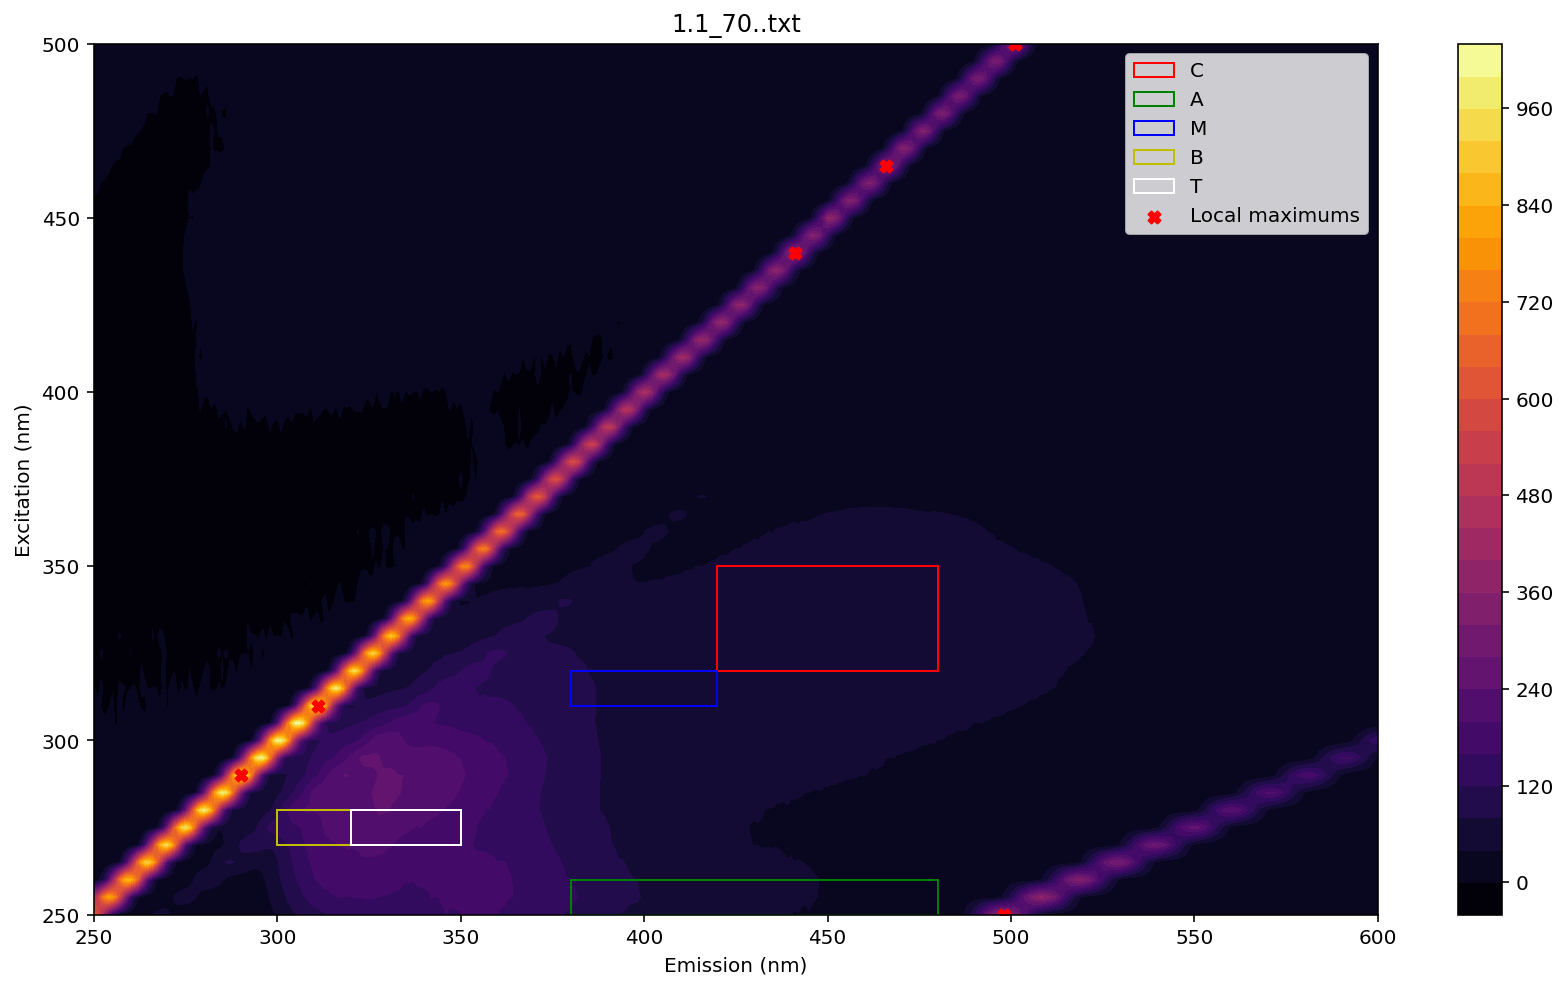

Correlation,"K, m1","K, m2"
Africa,0.321127,0.827296
North,-0.337818,0.955279


Africa,K,m2
1.1_70..txt,1.463542,0.273376
1.2_21.txt,1.922796,0.333485
1.3_68.txt,2.679532,0.499371
1.4_114.txt,1.708243,0.327983
1.5_11.txt,2.143091,0.370068
1.6_37.txt,1.948490,0.336029
2.3_5 (400).txt,2.622960,0.643876
2.3_5 (600).txt,1.708243,0.327983
2.3_5.txt,2.462687,0.638975
2.4_7.txt,2.274053,0.402768


North,K,m2
1701.txt,17.182651,2.474726
1702.txt,23.305749,3.496403
1702old.txt,17.945509,3.034029
1704.txt,17.523280,2.461407
1706.txt,5.399792,0.789786
1708_1to10.txt,23.901524,2.366542
1708_1to20.txt,4.508159,0.668021
1711.txt,11.189969,1.737484
1712.txt,0.587783,0.111257
1727.txt,5.187718,0.779121


[0.6438755477060077, 0.6770475786540538]
[0.6680211100257493, 0.7791212951436348, 0.7492948822740013]
percent_0_66 0.7666666666666667
percent_0_7 0.8
percent_0_75 0.8
percent_0_66 0.8888888888888888
percent_0_7 0.8333333333333334
percent_0_75 0.7777777777777778


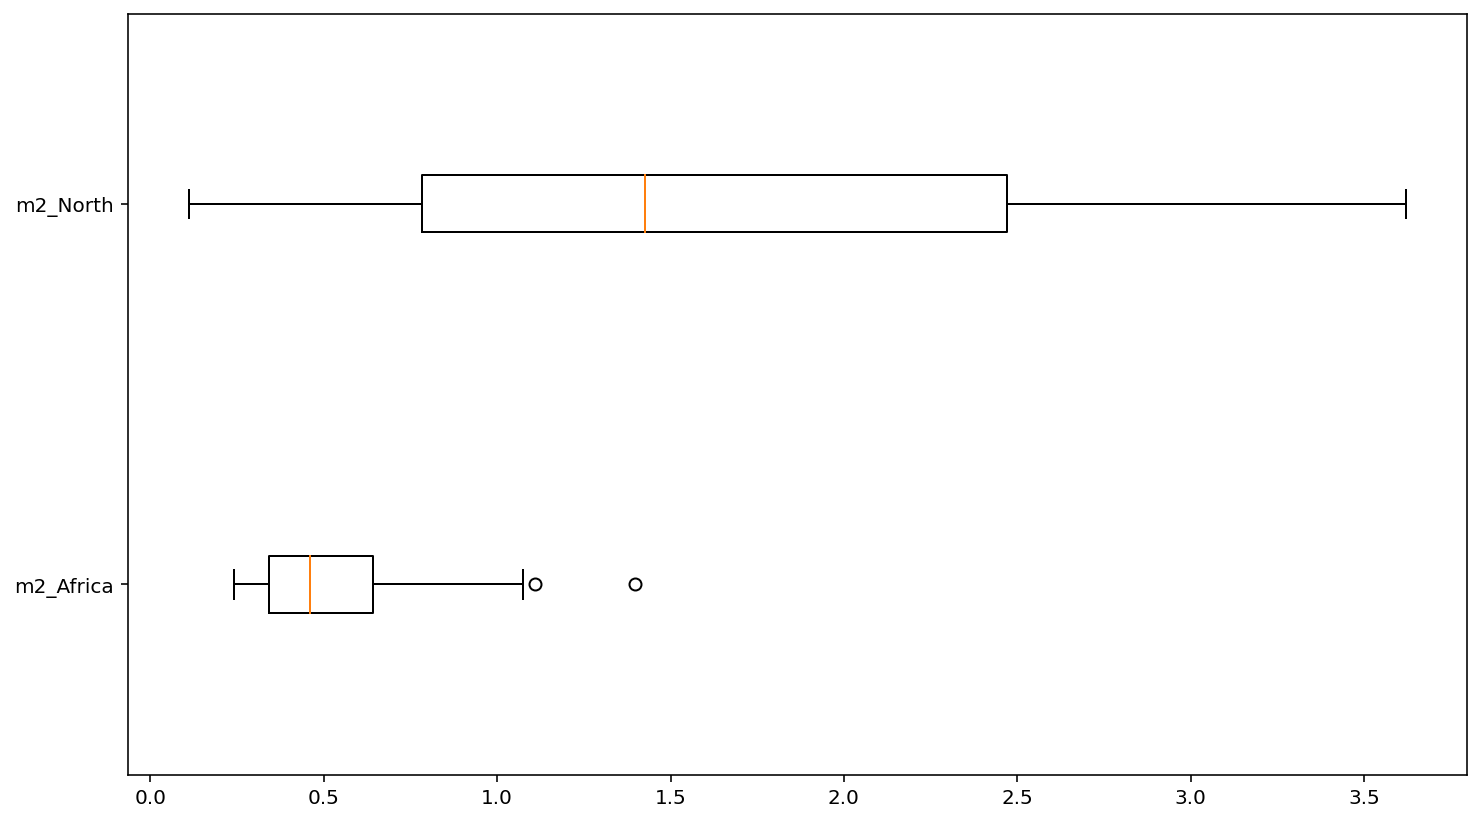

In [3]:
path_Africa = "ToBazhenov/Hexane_extr_Kivu_Lake/"
path_North = "ToBazhenov/VD_DOM_Permafrost/"
files_Africa = [
    "1.1_70.", "1.2_21", "1.3_68", "1.4_114", "1.5_11", "1.6_37",
    "2.3_5 (400)", "2.3_5 (600)", "2.3_5", "2.4_7", "3.1_14", "3.2_69",
    "3.3_15 (600)", "3.4_20(800)", "3.4_20", "3.5_43", "3.6_49(800)", "4.1_45",
    "4.2_80", "4.3_84", "4.4_87", "4.5_108", "4.6_88", "5.1_90", "5.2_2",
    "5.3_66", "5.3_66-1", "5.4_92", "5.5_28", "5.6_95"
]
files_North = [
    "1701", "1702", "1702old", "1704", "1706", "1708_1to10", "1708_1to20",
    "1711", "1712", "1727", "1728", "1728old", "1729", "1730", "1732", "1733",
    "1733old", "1734"
]
file_type = ".txt"

color = cm.get_cmap("inferno")
draw(path_Africa, files_Africa[0] + file_type, 'example')

table_Africa = pd.DataFrame([], columns=['K', 'm2'])
table_Africa.columns.name = 'Africa'
table_North = pd.DataFrame([], columns=['K', 'm2'])
table_North.columns.name = 'North'
correlation = pd.DataFrame([], columns=['K, m1', 'K, m2'])
correlation.columns.name = 'Correlation'

K_Africa, m1_Africa, m2_Africa = [], [], []
K_North, m1_North, m2_North = [], [], []

for file_Africa in files_Africa:
    sums = get_AA_sums(path_Africa + file_Africa + file_type)
    C, A, M, B, T = sums['C'], sums['A'], sums['M'], sums['B'], sums['T']

    K_Africa.append(get_K(C, A, B, T))
    m1_Africa.append(get_m1(M, C, A))
    m2_Africa.append(get_m2(M, B, T))
    table_Africa.loc[file_Africa + file_type] = [K_Africa[-1], m2_Africa[-1]]

for file_North in files_North:
    sums = get_AA_sums(path_North + file_North + file_type)
    C, A, M, B, T = sums['C'], sums['A'], sums['M'], sums['B'], sums['T']

    K_North.append(get_K(C, A, B, T))
    m1_North.append(get_m1(M, C, A))
    m2_North.append(get_m2(M, B, T))
    table_North.loc[file_North + file_type] = [K_North[-1], m2_North[-1]]

correlation.loc['Africa'] = [get_correlation_coeff(K_Africa, m1_Africa), get_correlation_coeff(K_Africa, m2_Africa)]
correlation.loc['North'] = [get_correlation_coeff(K_North, m1_North), get_correlation_coeff(K_North, m2_North)]

boxplot([m2_Africa, m2_North], ['m2_Africa', 'm2_North'], 'boxplot')
display(correlation)
display(table_Africa)
display(table_North)

# print(np.quantile(m2_Africa, 3 / 4))
# print(np.quantile(m2_North, 1 / 4))